# Retrieve forcing for any CAMELS catchment

In this notebook you will retrieve forcing from the Cravan dataset.The caravan dataset is a collection of streamflow and forcing data. <br>
Caravan was prepared by [Frederik Kratzert](https://doi.org/10.1038/s41597-023-01975-w), the forcing is based on the ERA5-Land model. The streamflow is from the USGS. <br>
To access it easily, it was stored [here](https://doi.org/10.4121/bf0eaf7c-f2fa-46f6-b8cd-77ad939dd350.v4) on the [OPenDAP](https://data.4tu.nl/info/about-your-data/netcdf-and-opendap) server from data.4TU.nl .<br>
This saves you from downloading and reading the whole dataset hosted on [zenodo](https://zenodo.org/records/6578598), instead only the necesarry data is downloaded. 

This notebook will show case how to run this for the HBV model. 

You have to supply the wanted basin_id. The shapefile will be downloaded automatically. 
Running the default will download the combined shapefile of all the catchments. 
Loading this combined shapefile and exploring it will show all availible catchments. 

In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from rich import print

In [2]:
# general eWC
import ewatercycle
import ewatercycle.forcing
import ewatercycle.models
import ewatercycle.analysis

#### set up paths

In [3]:
path = Path.cwd()
forcing_path = path / "Forcing"

#### add experiment info

In [4]:
experiment_start_date = "1997-08-01T00:00:00Z"
experiment_end_date = "2005-09-01T00:00:00Z"
HRU_id = 3439000

In [5]:
from ewatercycle.forcing import sources

In [6]:
print(sources)

ForcingSources[
    "DistributedMakkinkForcing",
    "DistributedUserForcing",
    "GenericDistributedForcing",
    "GenericLumpedForcing",
    "HBVForcing",
    "LumpedCaravanForcing",
    "LumpedMakkinkForcing",
    "LumpedUserForcing",
]

In [7]:
caravan_forcing = sources['LumpedCaravanForcing'].retrieve(start_time = experiment_start_date,
                                                          end_time = experiment_end_date,
                                                          directory = forcing_path / "Camels",
                                                          basin_id = f"camels_0{HRU_id}",
                                                          )

In [8]:
print(caravan_forcing)

LumpedCaravanForcing(
    start_time='1997-08-01T00:00:00Z',
    end_time='2005-09-01T00:00:00Z',
    directory=PosixPath('/home/davidhaasnoot/eWaterCycle-WSL-WIP/Forcing/Camels'),
    shape=PosixPath('/home/davidhaasnoot/eWaterCycle-WSL-WIP/Forcing/Camels/shapefiles/camels_03439000.shp'),
    filenames={
        'pr': 'camels_03439000_1997-08-01T00:00:00Z_2005-09-01T00:00:00Z_pr.nc',
        'tasmin': 'camels_03439000_1997-08-01T00:00:00Z_2005-09-01T00:00:00Z_tasmin.nc',
        'tas': 'camels_03439000_1997-08-01T00:00:00Z_2005-09-01T00:00:00Z_tas.nc',
        'tasmax': 'camels_03439000_1997-08-01T00:00:00Z_2005-09-01T00:00:00Z_tasmax.nc',
        'Q': 'camels_03439000_1997-08-01T00:00:00Z_2005-09-01T00:00:00Z_Q.nc',
        'evspsblpot': 'camels_03439000_1997-08-01T00:00:00Z_2005-09-01T00:00:00Z_evspsblpot.nc'
    }
)

In [9]:
ds_caravan = caravan_forcing.to_xarray()

In [10]:
ds_caravan

<xarray.Dataset> Size: 95kB
Dimensions:         (time: 2954)
Coordinates: (12/18)
  * time            (time) datetime64[ns] 24kB 1997-08-01 ... 2005-09-01
    basin_id        |S64 64B b'camels_03439000'
    timezone        |S64 64B b'America/New_York'
    name            |S64 64B b'FRENCH BROAD RIVER AT ROSMAN, NC'
    country         |S64 64B b'United States of America'
    lat             float64 8B 35.2
    ...              ...
    moisture_index  float64 8B -0.6997
    seasonality     float64 8B 0.2885
    high_prec_freq  float64 8B 0.04833
    high_prec_dur   float64 8B 1.155
    low_prec_freq   float64 8B 0.5741
    low_prec_dur    float64 8B 3.493
Data variables:
    Q               (time) float32 12kB ...
    evspsblpot      (time) float32 12kB ...
    pr              (time) float32 12kB ...
    tas             (time) float32 12kB ...
    tasmax          (time) float32 12kB ...
    tasmin          (time) float32 12kB ...

As you can see it will only download the required data variables needed for modeling

In [11]:
ds_caravan.data_vars

Data variables:
    Q           (time) float32 12kB ...
    evspsblpot  (time) float32 12kB ...
    pr          (time) float32 12kB ...
    tas         (time) float32 12kB ...
    tasmax      (time) float32 12kB ...
    tasmin      (time) float32 12kB ...

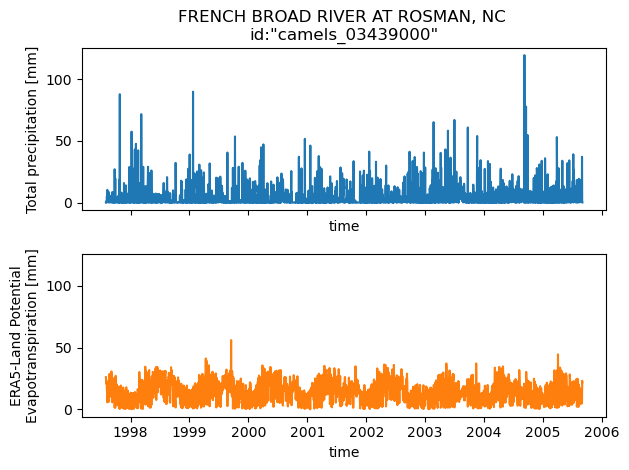

In [12]:
fig, ax = plt.subplots(2,1,sharex=True, sharey=True)
ds_caravan['pr'].plot(ax=ax[0],label="P")
ds_caravan['evspsblpot'].plot(ax=ax[1],label="E",color="C1")
ax[0].set_title(f'{ds_caravan.name.values.astype(str)} \nid:"{ds_caravan.basin_id.values.astype(str)}"');
ax[1].set_title(None)
fig.tight_layout()

#### setup model 

In [13]:
from ewatercycle.models import HBV

In [14]:
model = HBV(forcing=caravan_forcing)

#### pass parameters

In [15]:
s_0 = np.array([0,  100,  0,  5, 0])
par_0 = np.array([2,    0.8,  460,   1.5,    1.0,     4,    .4,   .04, 3])

In [16]:
config_file, _ = model.setup(
            parameters=','.join([str(p) for p in par_0]),
            initial_storage=','.join([str(s) for s in s_0]),
           )

In [17]:
model.initialize(config_file)

#### Run the model

In [18]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q"))
    time.append(model.time_as_datetime.date())

In [19]:
hydro_data = pd.DataFrame(data=Q_m,index=time,columns=["model output"])
hydro_data['discharge observations'] = ds_caravan['Q'].to_pandas()

In [20]:
hydro_data

,model output,discharge observations
1997-08-02,0.026010,1.98
1997-08-03,0.103941,1.88
1997-08-04,0.181524,1.80
1997-08-05,0.206589,1.73
1997-08-06,0.205208,1.68
...,...,...
2005-08-28,0.892164,3.15
2005-08-29,0.694578,3.17
2005-08-30,0.662286,9.59
2005-08-31,1.037895,6.15


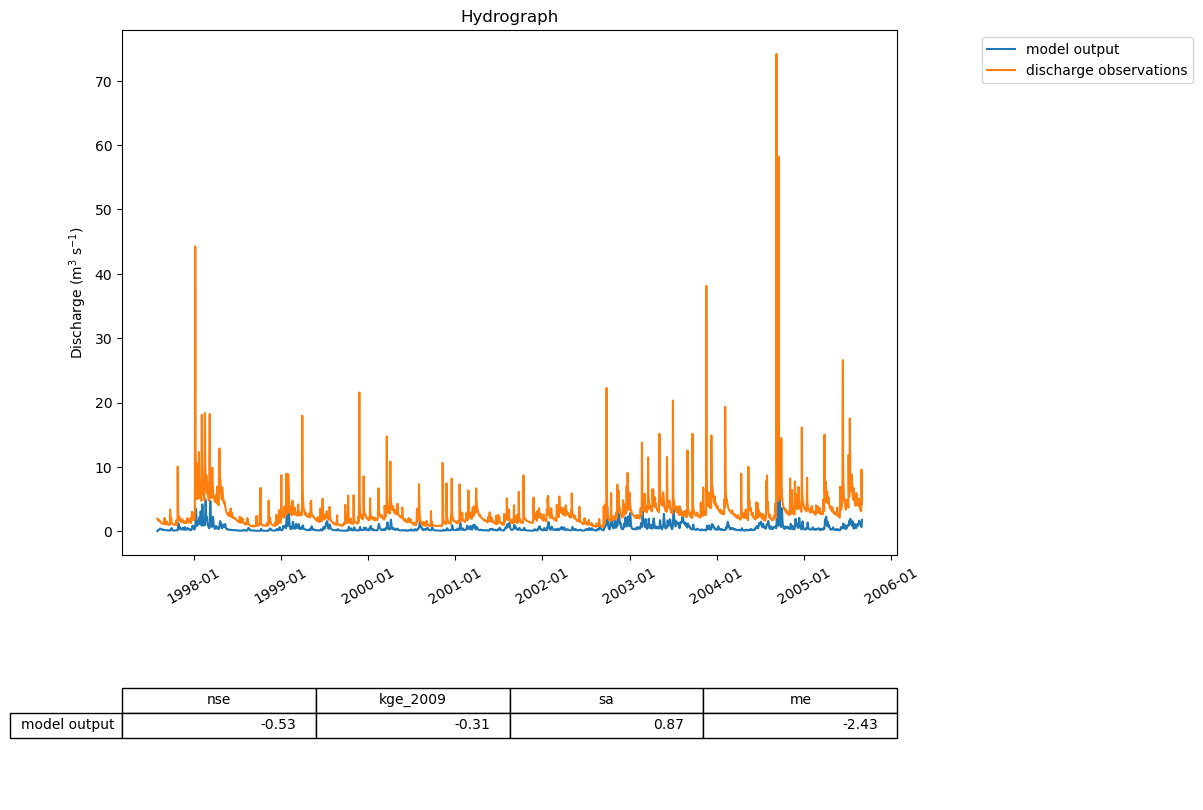

In [21]:
ewatercycle.analysis.hydrograph(hydro_data, reference='discharge observations');

In [22]:
model.finalize()

### Basins

Using the shapefile we can look at the location of the basin on a map

In [23]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

I use geopandas:
```py
pip install geopandas
```
as using shapely/cartopy is a hastle

In [24]:
import geopandas as gpd

In [25]:
gdf_basin = gpd.read_file(caravan_forcing.shape)
gdf_basin_buffer = gdf_basin.buffer(1.5)

In [26]:
gdf_basin

,gauge_id,geometry
0,camels_03439000,"POLYGON ((-82.88278 35.30930, -82.87511 35.301..."


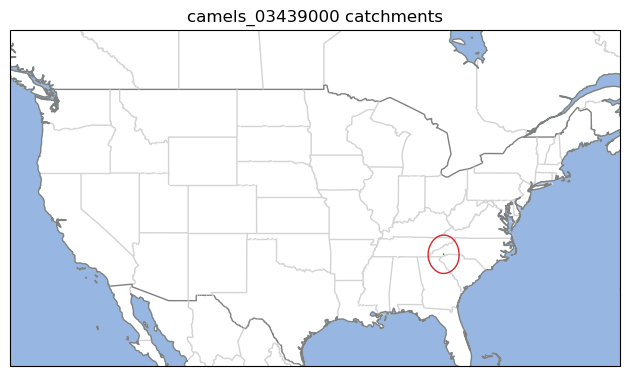

In [27]:
# fig, ax = plt.subplots()
ax = plt.axes(projection=ccrs.PlateCarree())
country_borders = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_boundary_lines_land',
    scale='10m',
    facecolor='none')
ax.add_feature(country_borders, edgecolor='gray')

state_borders = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')
ax.add_feature(state_borders, edgecolor='lightgray')
ax.add_feature(cfeature.COASTLINE, edgecolor='gray')
ax.add_feature(cfeature.OCEAN, edgecolor='lightblue')


gdf_basin.plot(ax=ax,facecolor="green")
gdf_basin_buffer.plot(ax=ax,facecolor="None", edgecolor="C3",zorder=10)

ax.set_title(f"{gdf_basin.loc[0,'gauge_id']} catchments")
ax.set_extent([-127.275,  -64.853, 25.864, 50.101], crs=ccrs.Geodetic())

plt.tight_layout()

##### and with the combined shapefile we see the all the basins

In [28]:
gdf_all = gpd.read_file(caravan_forcing.shape.parent / 'combined.shp')

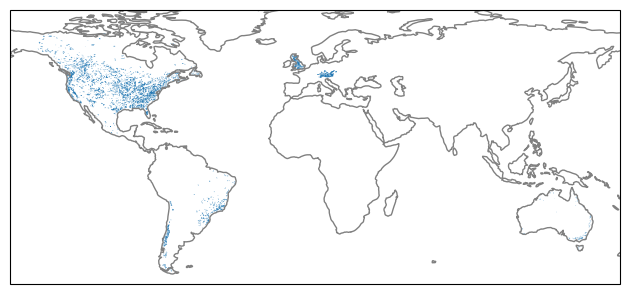

In [29]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, edgecolor='gray')
gdf_all.plot(ax=ax,zorder=1,color="C0")
plt.tight_layout()

In [30]:
gdf_all

,gauge_id,geometry
0,camels_01022500,"POLYGON ((-67.97836 44.61310, -67.98141 44.614..."
1,camels_01031500,"MULTIPOLYGON (((-69.31629 45.15325, -69.32144 ..."
2,camels_01047000,"POLYGON ((-70.10847 45.21669, -70.10609 45.213..."
3,camels_01052500,"POLYGON ((-71.10862 45.12730, -71.10402 45.125..."
4,camels_01054200,"POLYGON ((-70.97999 44.39574, -70.97657 44.393..."
...,...,...
6825,lamah_47840,"POLYGON ((9.55616 48.16253, 9.56571 48.15944, ..."
6826,lamah_76175,"POLYGON ((9.88750 48.38333, 9.88529 48.38277, ..."
6827,lamah_76176,"POLYGON ((10.38109 48.87520, 10.37946 48.87519..."
6828,lamah_76184,"POLYGON ((9.75509 48.31759, 9.75364 48.31563, ..."
